# Use case 1: Clustering of Drivers with K-Means 

In this use case, we group drivers into several clusters based on their driving speed and distance, using K-Means clustering technique.

**Clustering** is a technique where the goal is to group data points into clusters, or groups, based on their similarities. 
- The idea is that data points within the same cluster should be more similar to each other than to those in other clusters
- It’s commonly used in machine learning and statistics to explore patterns in data and is a type of unsupervised learning since it doesn’t require labeled data

  
**K-Means**

It is a clustering algorithm that groups data into  K  clusters by minimizing within-cluster variance (inertia)
- It assigns points to the nearest cluster centroid
- Recalculating centroids iteratively until stabilization
- It requires specifying  K  in advance, assumes spherical clusters
- It is sensitive to outliers and initial centroids

___

**Students:**
- OUEDRAOGO Taoufiq
- TONDJI Andrea
- YATTASSAYE Ganda
- NANFAH Manoel
___

In [1254]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sweetviz as sv
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

In [1244]:
df = pd.read_csv('data/Driver_data.csv')
print(df.shape)
df.head()

(4000, 3)


,Driver_ID,Distance_Feature,Speeding_Feature
0,3423311935,71.24,28
1,3423313212,52.53,25
2,3423313724,64.54,27
3,3423311373,55.69,22
4,3423310999,54.58,25


## Exploratory Data Analysis

In [493]:
pd.concat([
    df.describe(), 
    df.var().to_frame(name='variance').T,
    df.dtypes.to_frame(name='dtype').T,
    df.nunique().to_frame(name='#unique values').T,
    df.isna().sum().to_frame(name='#NaN').T        
])

,Driver_ID,Distance_Feature,Speeding_Feature
count,4000.0,4000.0,4000.0
mean,3423312447.5,76.041522,10.721
std,1154.844867,53.469563,13.708543
min,3423310448.0,15.52,0.0
25%,3423311447.75,45.2475,4.0
50%,3423312447.5,53.33,6.0
75%,3423313447.25,65.6325,9.0
max,3423314447.0,244.79,100.0
variance,1333666.666667,2858.994122,187.92414
dtype,int64,float64,int64


### NaN Values Visualisation

A heatmap to visualize missing values (NaN)
- missing values would be represented as white lines for each column

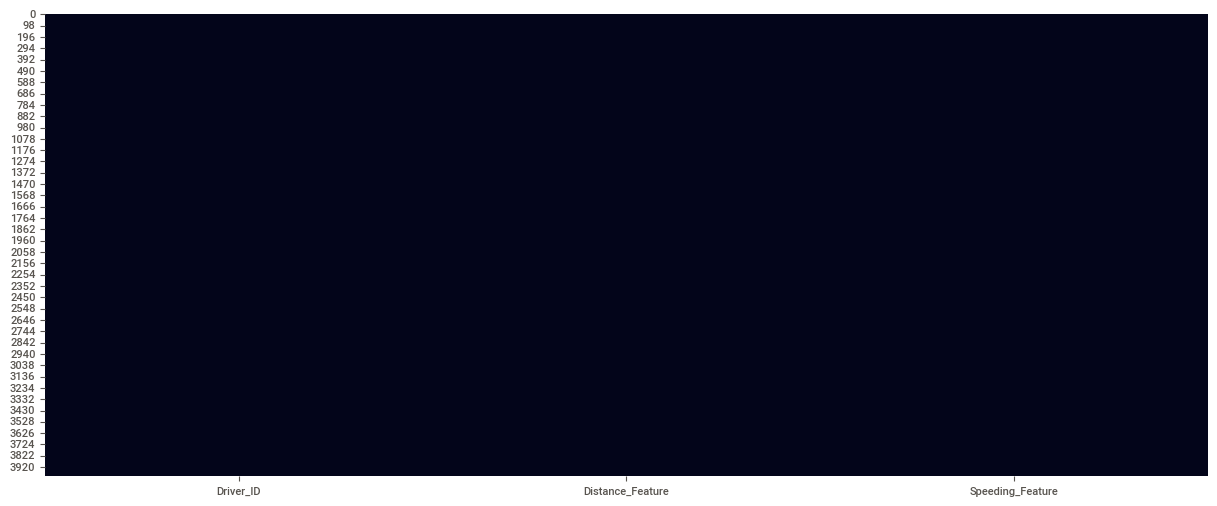

In [298]:
plt.figure(figsize=(15,6))
sns.heatmap(df.isna(), cbar=False)
plt.show()

### Removing column `Driver_ID`

The `Driver_ID` should be removed because:
- It’s just a unique identifier for each driver and doesn’t help in clustering based on driving patterns
- Including it adds noise to the model and distracts the algorithm from meaningful features like `Distance_Feature` and `Speeding_Feature`
- That could lead to irrelevant or overly detailed clusters, since each driver is treated as unique without any relation to driving behavior
- With 4000 unique values (over 4000 lines of data), it introduces unnecessary variance that doesn’t help the clustering process

Removing `Driver_ID` ensures the clustering focuses on the relevant driving features

In [1245]:
# Drop the 'Driver_ID' column from the DataFrame
df = df.drop(columns=['Driver_ID'])
df.head()

,Distance_Feature,Speeding_Feature
0,71.24,28
1,52.53,25
2,64.54,27
3,55.69,22
4,54.58,25


                                             |      | [  0%]   00:00 -> (? left)


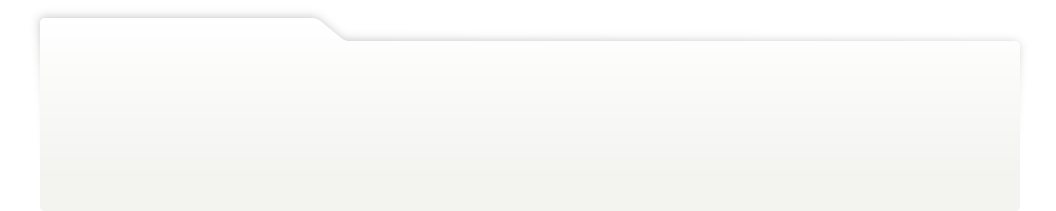
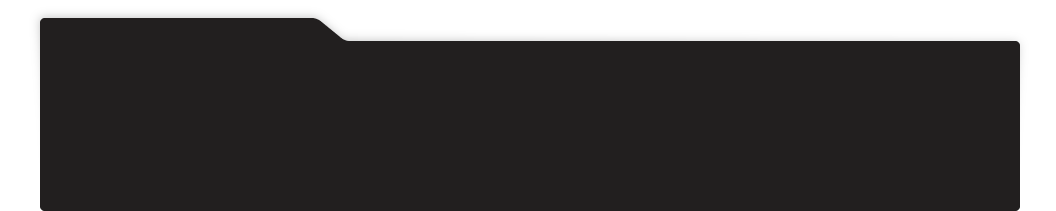
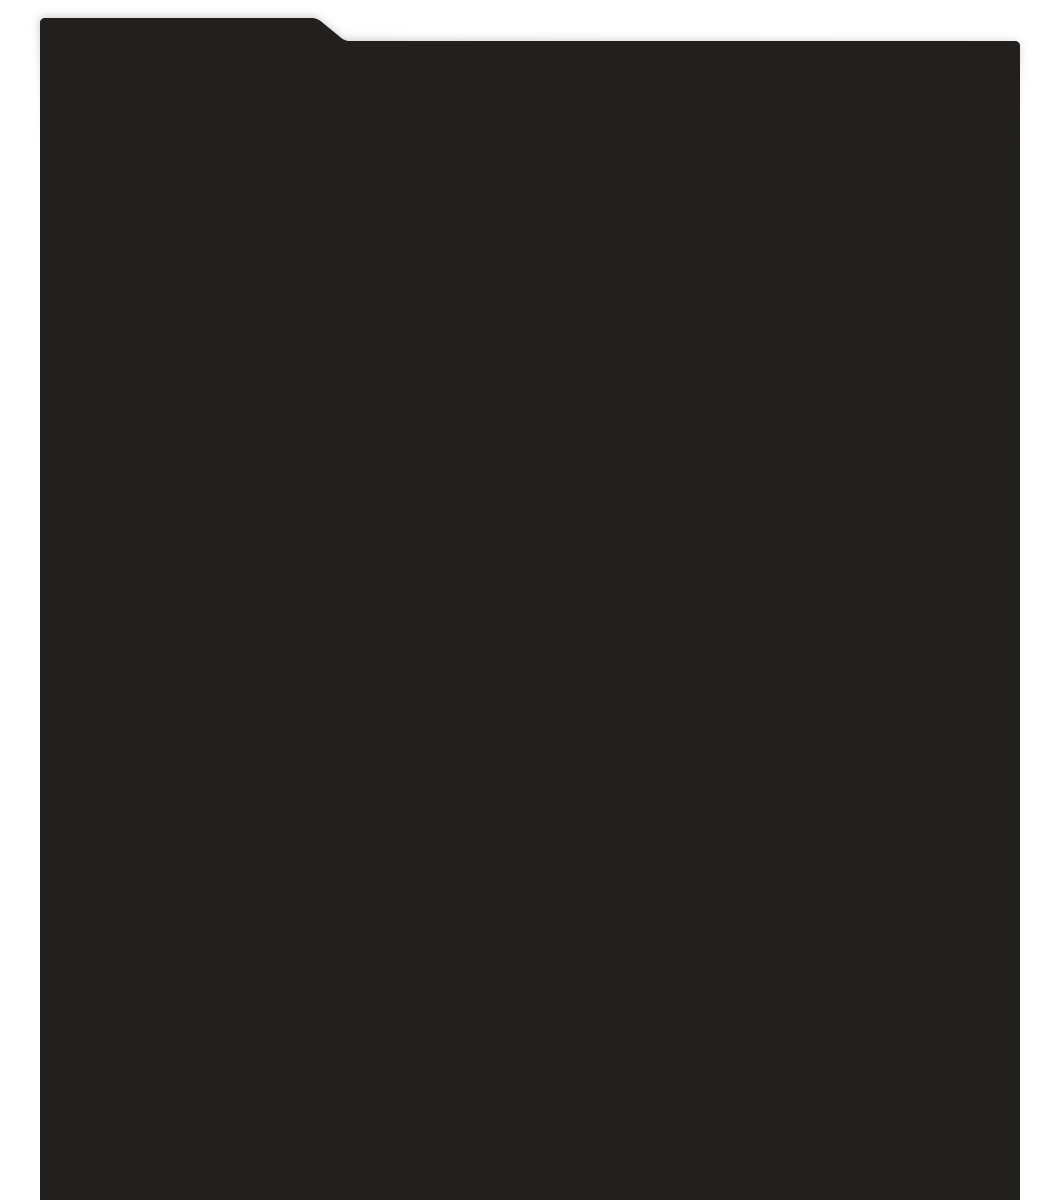
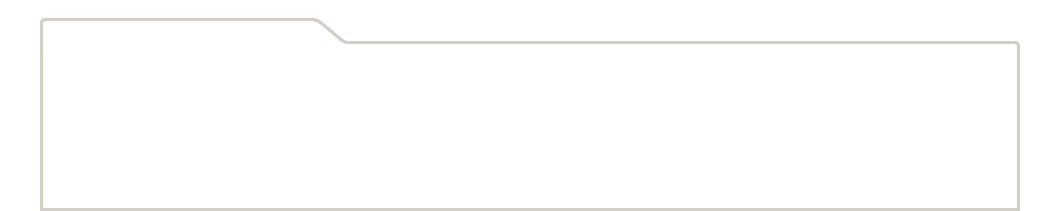
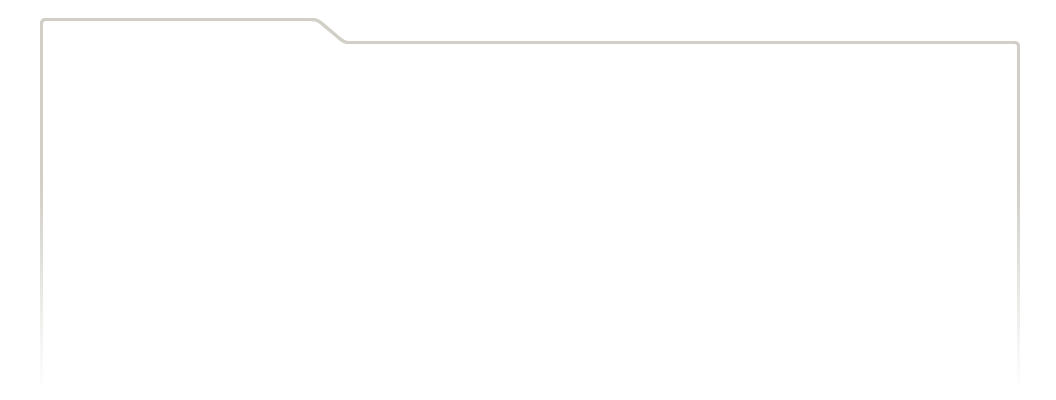
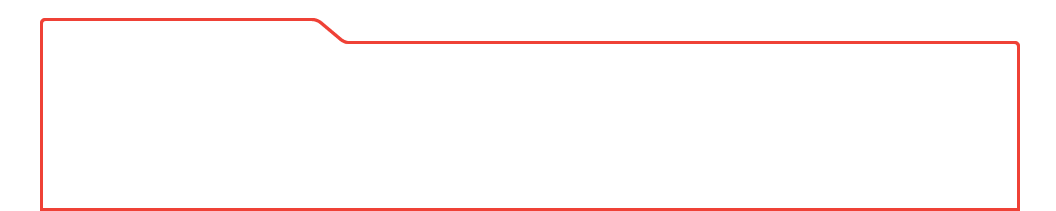
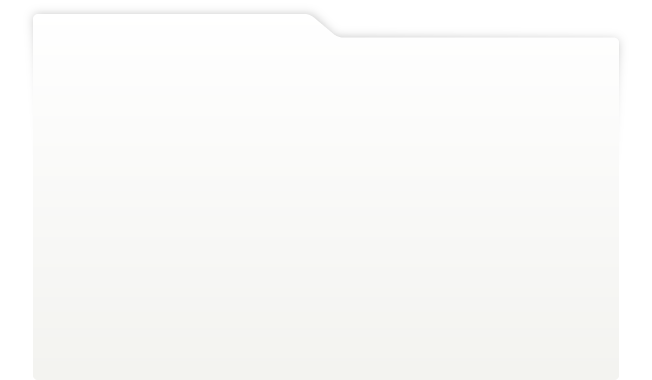
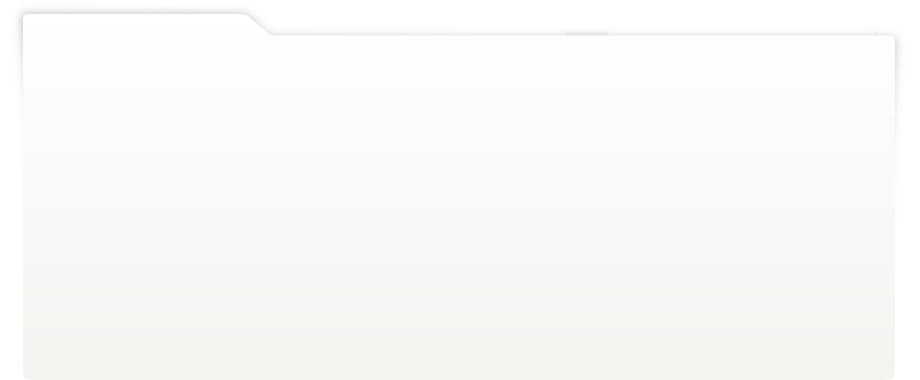
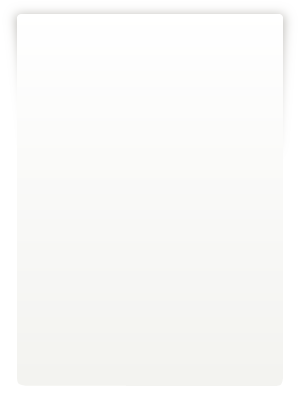
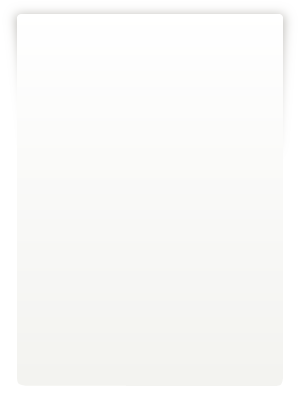
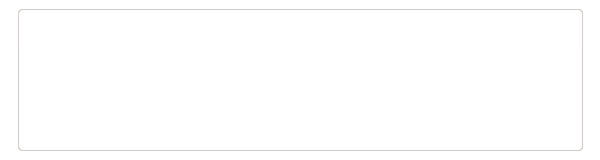
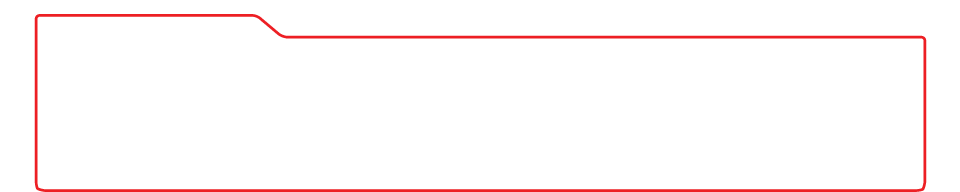
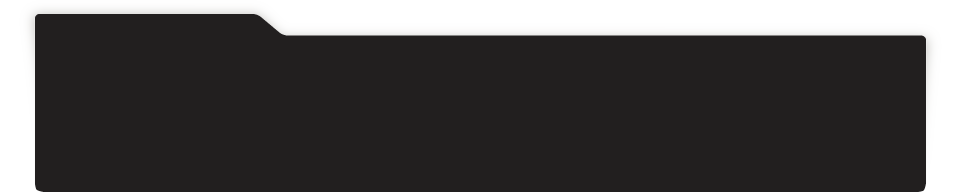
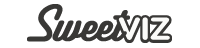
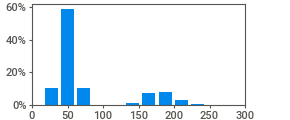
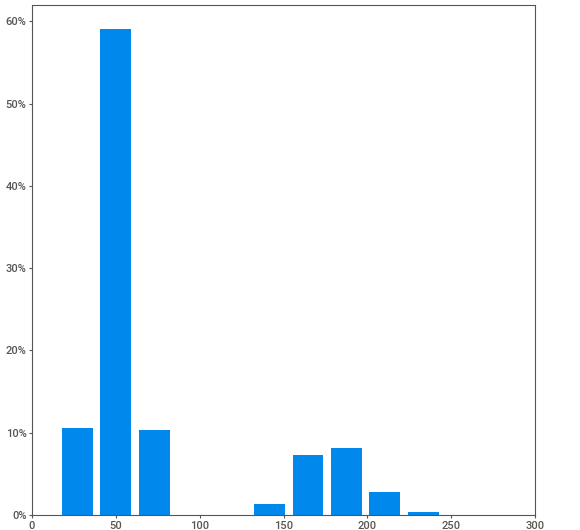
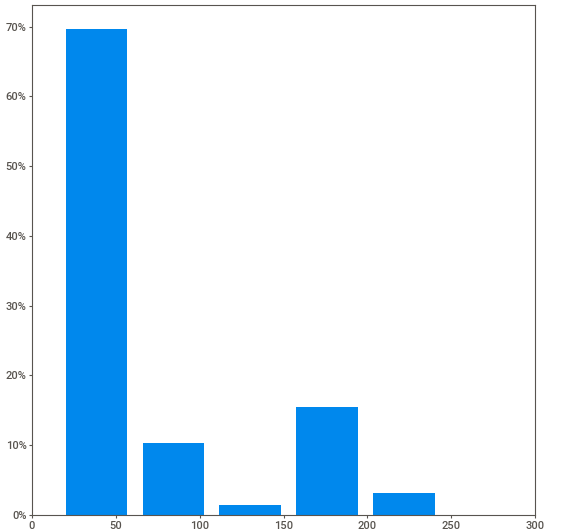
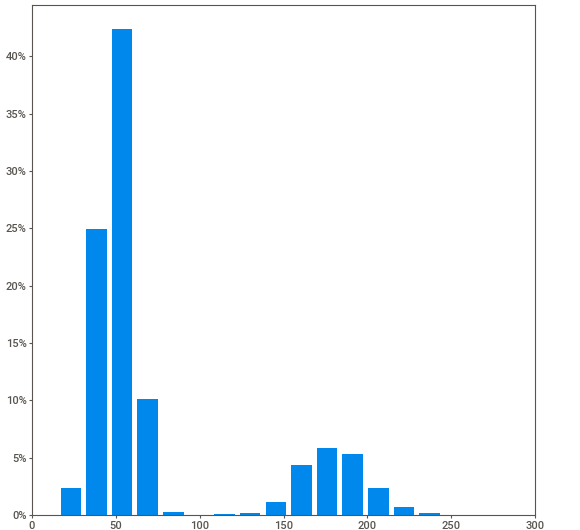
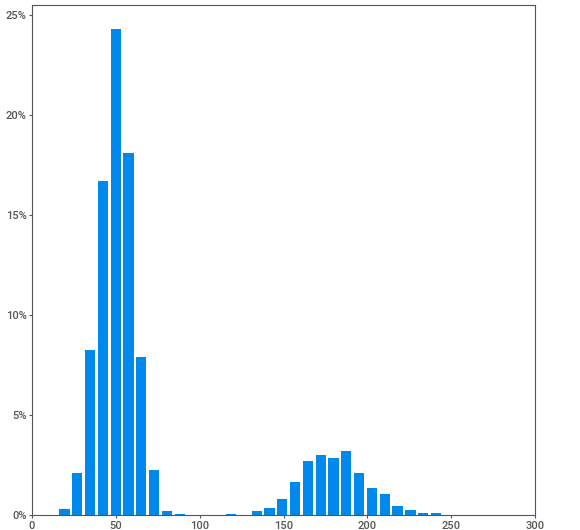
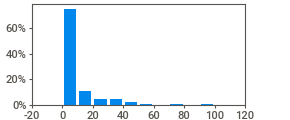
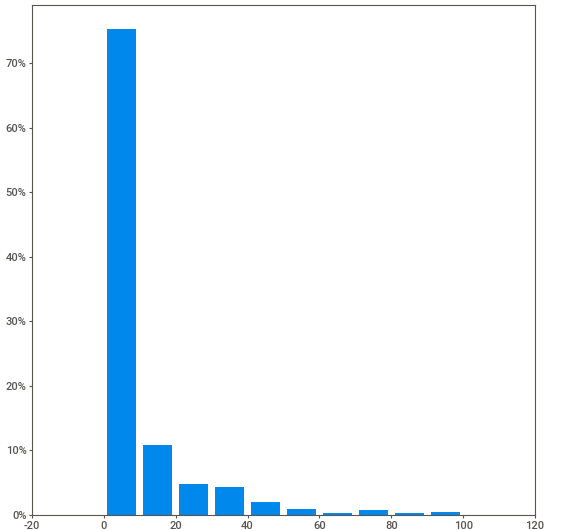
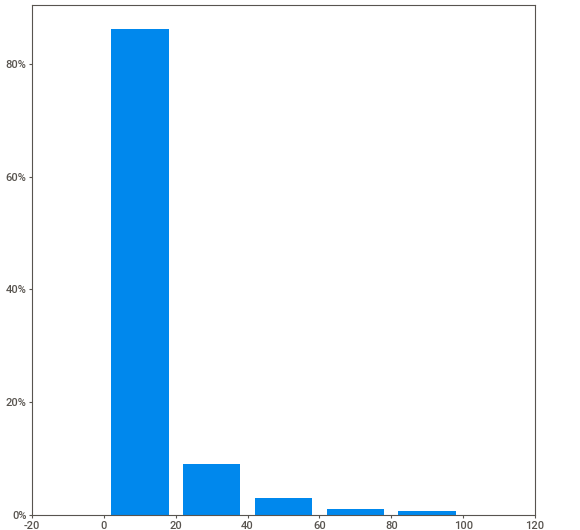
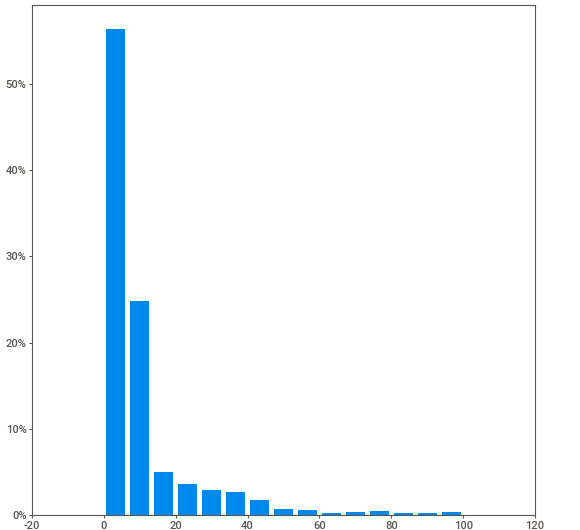
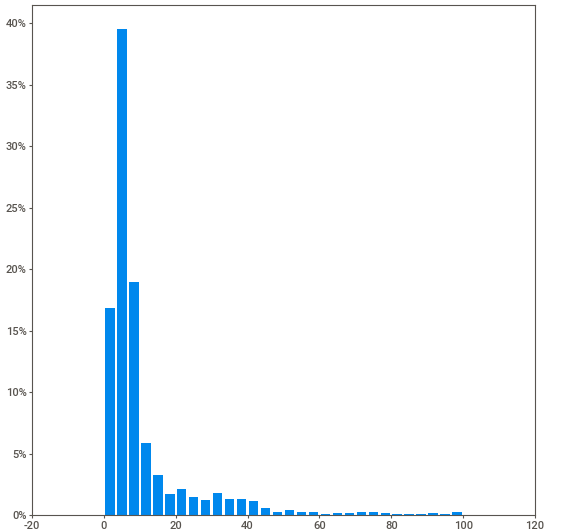
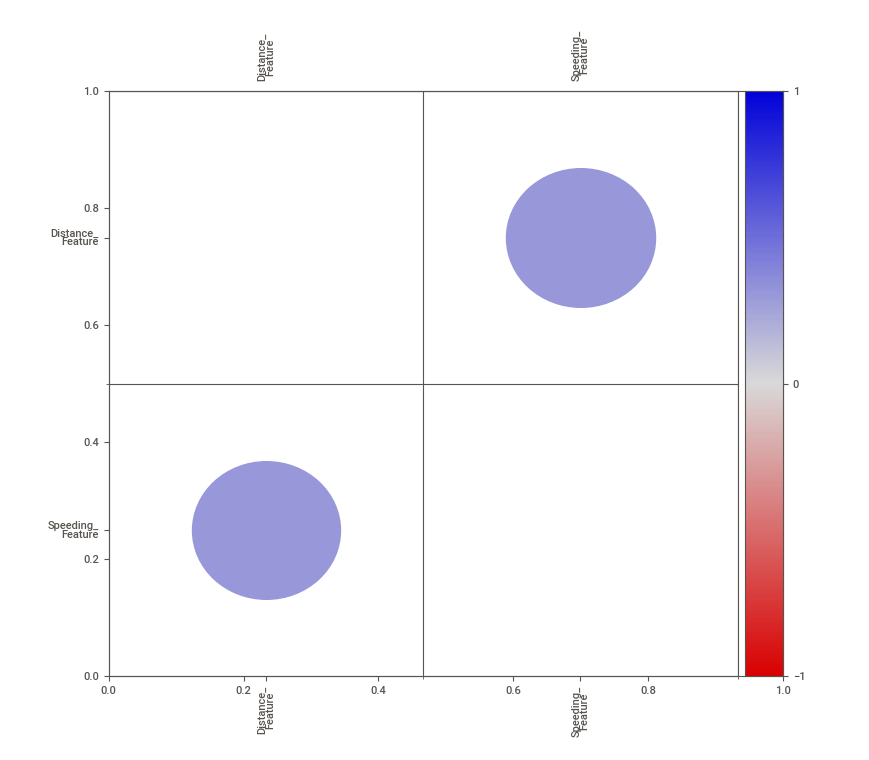
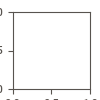

In [301]:
# EDA: Sweetviz library to summarize main characteristics of the dataset
report = sv.analyze(df)
report.show_notebook(layout="vertical", w=880, h=500, scale=0.8)

<Figure size 1500x400 with 0 Axes>

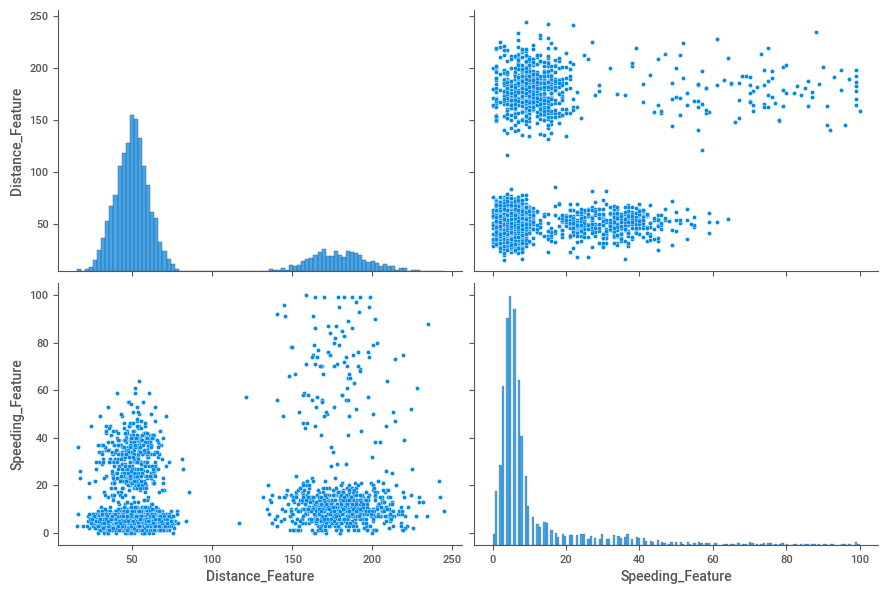

In [412]:
plt.figure(figsize=(15, 4))
sns.pairplot(data=df,height=3, aspect=1.5)
plt.show()

## Correlation

Correlation measures the strength of a relationship between 2 variables and the direction of that relationship
- Pearson Correlation: Measures the linear relationship between two variables
- Spearman Correlation: Measures the monotonic relationship between two variables
- Kendall Correlation: Measures the ordinal association between two variables

**Interpretation**

- The low value of Pearson Correlation indicates a weak positive linear relationship. As one feature increases, the other tends to increase slightly, since the relationship is not strong
- The Spearman Correlation indicates a weak positive monotonic relationship
- The Kendall Correlation shows a weak positive ordinal association between the two features
  
> **All 3 metrics indicate a weak positive relationship between `Distance_Feature` and `Speeding_Feature`**

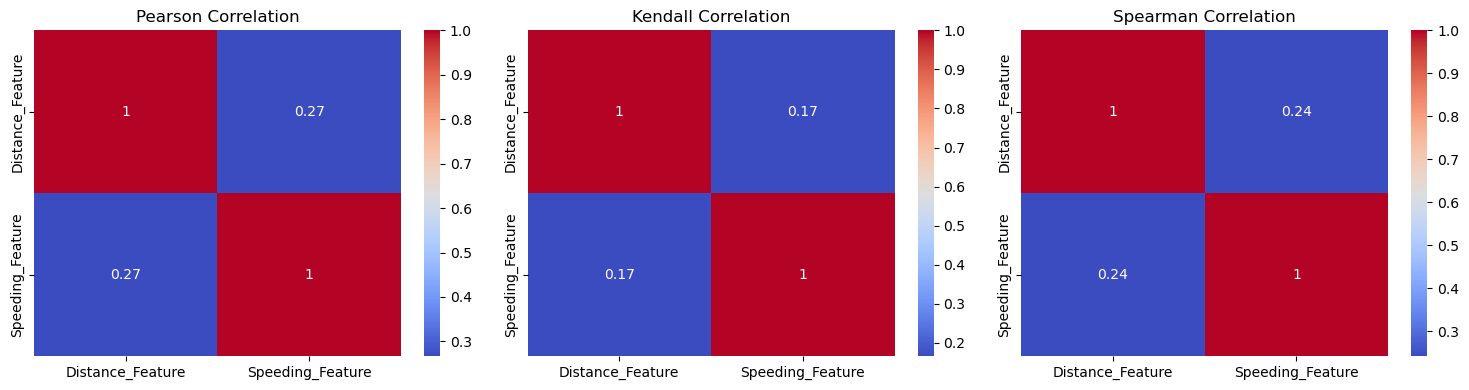

In [226]:
# Compute the correlation matrices with different methods
corr_pearson = df.corr(method='pearson')
corr_kendall = df.corr(method='kendall')
corr_spearman = df.corr(method='spearman')

# Pearson Correlation Heatmap
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=axes[0], cbar=True)
axes[0].set_title('Pearson Correlation')

# Kendall Correlation Heatmap
sns.heatmap(corr_kendall, annot=True, cmap='coolwarm', ax=axes[1], cbar=True)
axes[1].set_title('Kendall Correlation')

# Spearman Correlation Heatmap
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=axes[2], cbar=True)
axes[2].set_title('Spearman Correlation')
plt.tight_layout()
plt.show()

## Histograms and Boxplots


**Skewness (Asymétrie)** 
- A measure that indicates the degree and direction of asymmetry in a distribution
- Showing whether data values are more concentrated on one side of the mean 
- For Right-Skewed Distribution: data values are more concentrated on the left
- For Left-Skewed Distribution: data values are more concentrated on the right

$$ \text{Skewness = } \sum_{i=1}^{n}\frac{(X_{i}-\bar{X})^{3}}{n . \sigma_{X}^{3}}  = 
\begin{cases}
     0 \text{ , for Normal distribution}\\
    > 0 \text{ , for Right-Skewed distribution} \\
    < 0 \text{ , for Left-Skewed distribution}
\end{cases} 
$$


**Kurtosis (Applatissement des queues)**
- A measure that describes the shape of a distribution’s tails
- Indicating whether it has heavier or lighter tails compared to a normal distribution
- Reflecting the presence of outliers (as the histogram shows the probability of an event occurring)

$$  \text{Kurtosis} = \sum_{i=1}^{n} \frac{(X_{i}-\bar{X})^{4}}{n . \sigma^{4}} = 
\begin{cases}
    = 3 \text{ , for Normal distribution}\\
    > 3 \text{ , for Fat/Heavy tail) distribution} \\
    < 3 \text{ , for Thin/Light tail) distribution}
\end{cases} 
$$


### Interpretation

For `Distance_Feature`
- The distribution is right-skewed (Skewness=1.49), indicating that the majority of values are concentrated at the left
- Kurtosis (0.56) suggests that the distribution is relatively flat compared to a normal distribution

For `Speeding_Feature`
- The distribution is heavily right-skewed (Skewness=3.21)
- Skewness (1.49) indicates that the majority of values are concentrated at the left
- Kurtosis (12.31) showing a sharp peak with heavy tails

  
> The skewness and kurtosis indicate a non-symmetric distribution with some spread for the features
> 
> Features have extreme variation due to their distribution dominated by outliers
>
> Strong concentration at lower values are also noticeable
>
> These may influence clustering, as K-Means assumes spherical clusters
>
> Data transformation or normalization may be required


In [812]:
pd.concat([
    df.skew().to_frame(name='Skewness'),
    df.kurt().to_frame(name='nKurtosis'),
], axis=1)

,Skewness,nKurtosis
Distance_Feature,1.490008,0.562528
Speeding_Feature,3.218771,12.315822


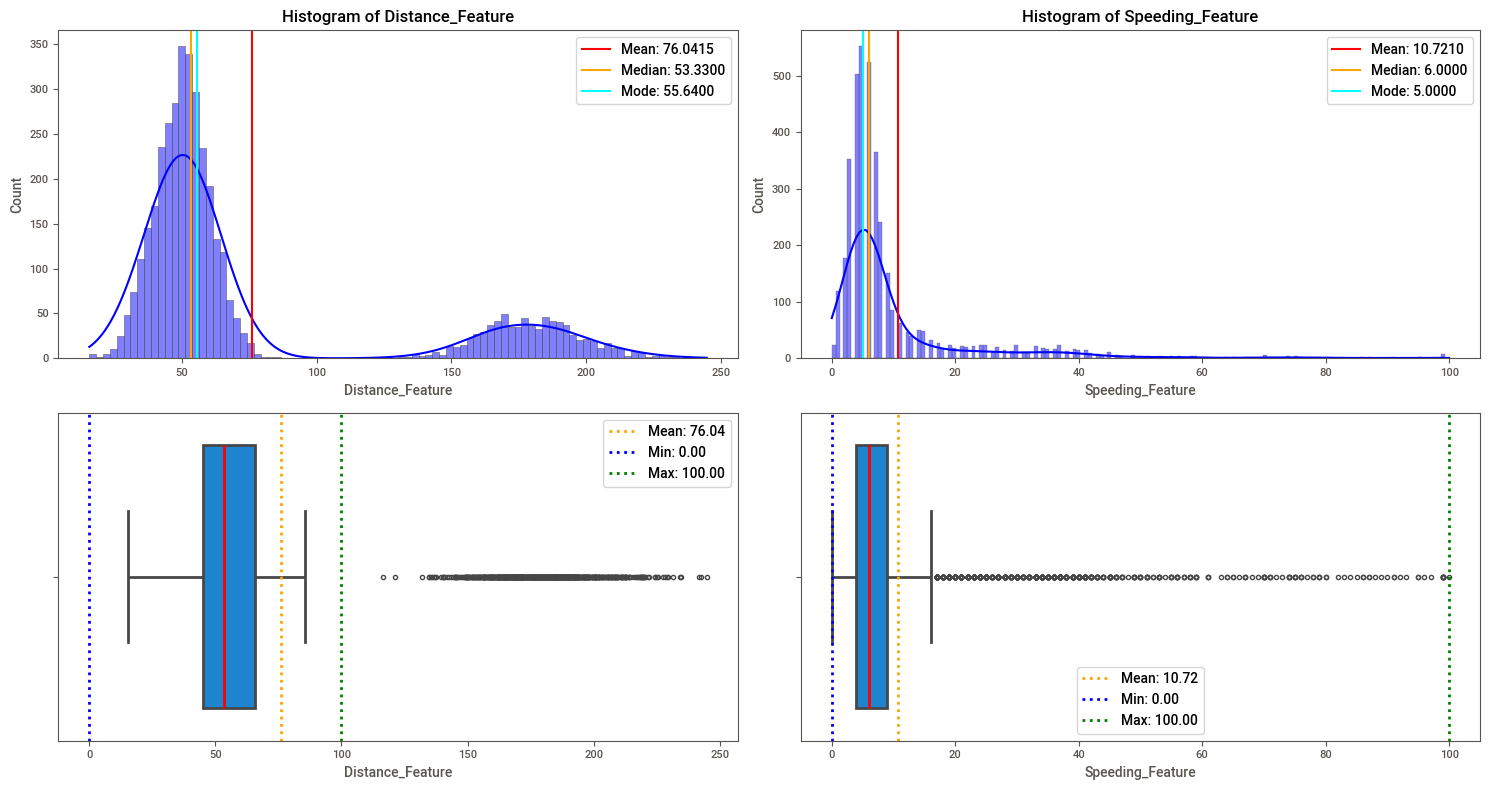

In [814]:
fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(15, 8))
for i in range(n):
    c = df.columns[i]
    mean = df[c].mean()
    median = df[c].median()
    mode = df[c].mode()[0]

    # Plot the histogram with kde
    sns.histplot(data=df, x=c, ax=axes[0, i], kde=True, color='b')  
    axes[0, i].set_title(f'Histogram of {df.columns[i]}')
    
    # Plot the mean, median, and mode lines on the histogram
    axes[0, i].axvline(mean, color='r', label=f'Mean: {mean:.4f}')
    axes[0, i].axvline(median, color='orange', label=f'Median: {median:.4f}')
    axes[0, i].axvline(mode, color='cyan', label=f'Mode: {mode:.4f}')
    axes[0, i].legend()

    # Plot the boxplot with custom vertical lines for mean, min, and max
    sns.boxplot(data=df, x=c, ax=axes[1, i], linewidth=2, 
                medianprops=dict(color="red", linewidth=2))
    
    # Add custom vertical lines for mean, min, and max on the boxplot
    axes[1, i].axvline(mean, color='orange', linestyle=':', linewidth=2, label=f'Mean: {mean:.2f}')
    axes[1, i].axvline(min_, color='blue', linestyle=':', linewidth=2, label=f'Min: {min_:.2f}')
    axes[1, i].axvline(max_, color='green', linestyle=':', linewidth=2, label=f'Max: {max_:.2f}')
    axes[1, i].legend()    
plt.tight_layout()
plt.show()

## Outlier Detection

#### Z-Score
- Quantifies how far a data point is from the mean, in terms of standard deviations
- Points with Z-scores greater than 3 or less than -3 are considered outliers.

$$Z_i = \frac{x_i - \mu}{\sigma} =
\begin{cases}
    > 3 \text{ , point is considered as an Outlier}\\
    < - 3 \text{ , point is considered as an Outlier} 
\end{cases} 
$$

**Why 3 * std?**

In a normal distribution $N(\mu, \sigma^2)$:
- 68% of data $\in \mu \pm 1.\sigma$
- 95% of data $\in \mu \pm 2.\sigma$
- 99.7% of data $\in \mu \pm 3.\sigma$


### IQR (Inter Quartile Range) Method

Another method to detect outliers is by computing the IQR

Outliers are points that fall outside the range $[\text{Q1} - 1.5 \text{.IQR}, \text{Q3} + 1.5 \text{.IQR}]$

$$\text{IQR} = Q3 - Q1 $$ 


Z-score and IQR method identifies outliers differently:
- Z-score is independent on the assumption of normality in the data
- IQR particularly useful for data that is not normally distributed
- We should combine both methods to confirm the outliers’ significance

In [1267]:
def get_z_score_outliers(df, c):
  # Calculate Z-scores
  z_scores = (df[c] - df[c].mean()) / df[c].std()
  # Identify outliers (Z-score > 3 or < -3)
  outliers = z_scores[abs(z_scores) > 3]
  return pd.DataFrame(outliers)


def get_iqr_outliers(df, c):
  # Calculate IQR 
  Q1 = df[c].quantile(0.25)
  Q3 = df[c].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Identify outliers using IQR
  iqr_outliers = df[c][(df[c] < lower_bound) | (df[c] > upper_bound)]
  return pd.DataFrame(iqr_outliers)

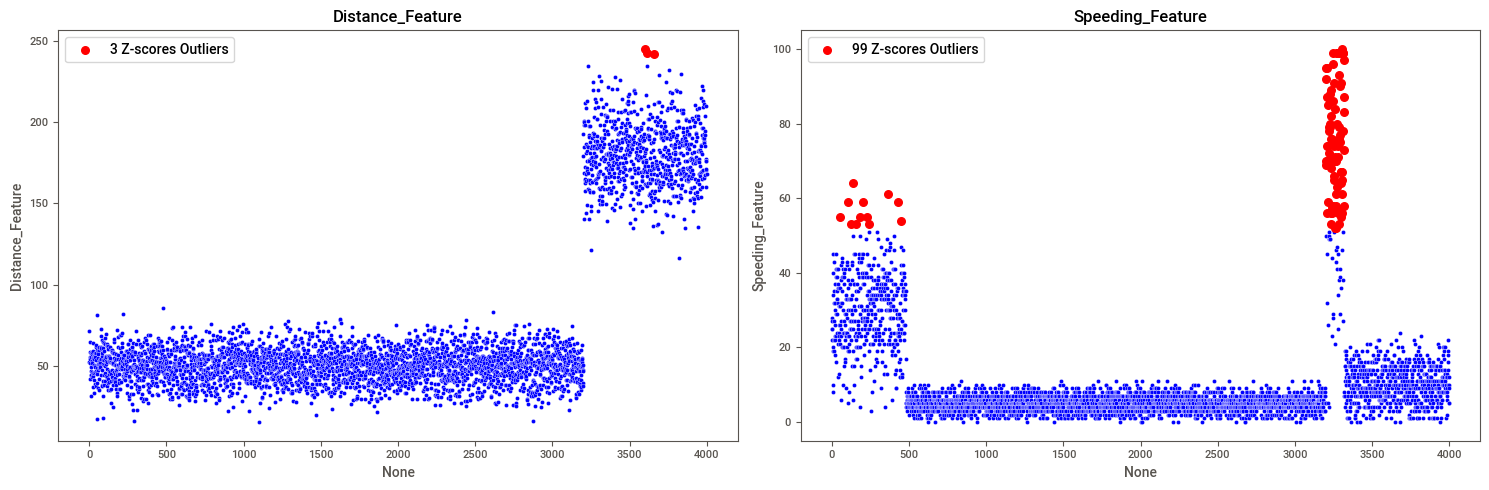

In [1265]:
fig, axes = plt.subplots(1, n, figsize=(15, 5))
for i, c in enumerate(df.columns):  
    ax = axes[i]  
    sns.scatterplot(x=df.index, y=df[c], ax=ax, c='b')    
    z_score_outliers = get_z_score_outliers(df, c)
    ax.scatter(z_score_outliers.index, df[c][z_score_outliers.index], 
            color='red', label=f'{len(z_score_outliers)} Z-scores Outliers', s=30)
    ax.set_title(f"{c}")
    ax.legend(loc="best")
plt.tight_layout()
plt.show()

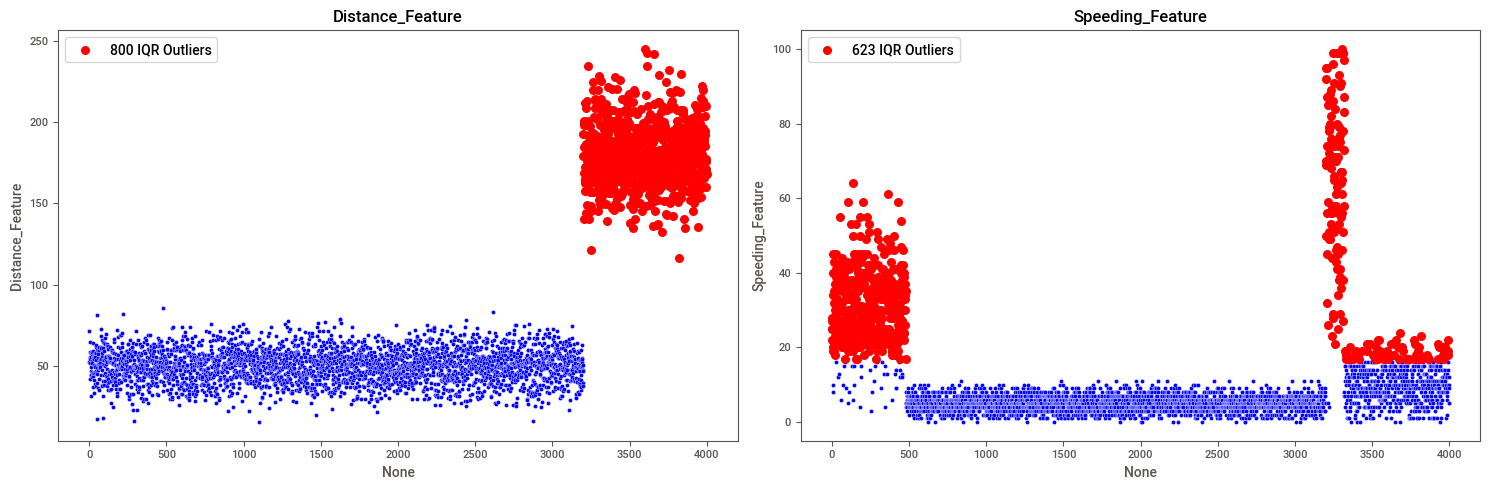

In [1266]:
fig, axes = plt.subplots(1, n, figsize=(15, 5))
for i, c in enumerate(df.columns):  
    ax = axes[i]  
    sns.scatterplot(x=df.index, y=df[c], ax=ax, c='b')    
    iqr_outliers = get_iqr_outliers(df, c)
    ax.scatter(iqr_outliers.index, df[c][iqr_outliers.index], 
            color='red', label=f'{len(iqr_outliers)} IQR Outliers', s=30)
    ax.set_title(f"{c}")
    ax.legend(loc="best")
plt.tight_layout()
plt.show()

## Variable Relationship

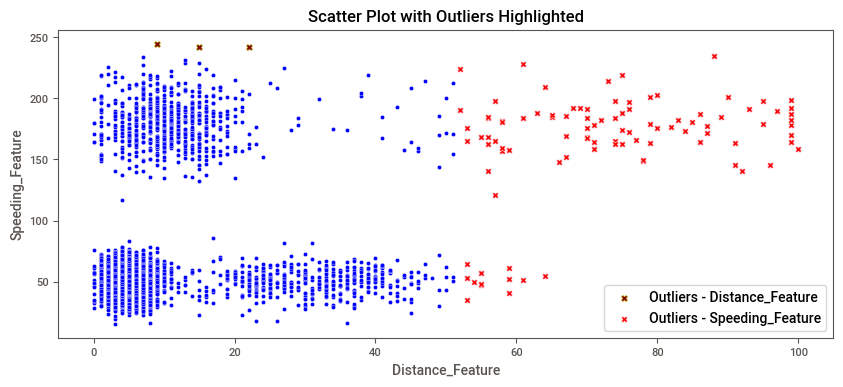

In [498]:
outlier_distance = outliers['Distance_Feature'] == True
outlier_speeding = outliers['Speeding_Feature'] == True
outlier_both = outlier_distance & outlier_speeding

# Plot the normal data
plt.subplots(figsize=(10, 4))
sns.scatterplot(data=df, y='Distance_Feature', x='Speeding_Feature', c='b')
sns.scatterplot(data=df[outlier_distance], y='Distance_Feature', x='Speeding_Feature', 
                marker='X', color='maroon', edgecolors='y', s=20, label='Outliers - Distance_Feature')
sns.scatterplot(data=df[outlier_speeding], y='Distance_Feature', x='Speeding_Feature',
                marker='X', color='red', s=20, label='Outliers - Speeding_Feature')
sns.scatterplot(data=df[outlier_both], y='Distance_Feature', x='Speeding_Feature',
                marker='X', color='purple', s=20, label='Outliers - Both')
plt.xlabel('Distance_Feature')
plt.ylabel('Speeding_Feature')
plt.title('Scatter Plot with Outliers Highlighted')
plt.legend()
plt.show()

For the chart on the left
- The hottest areas in colour represent the places where point densities are highest
- There is in fact no apparent correlation

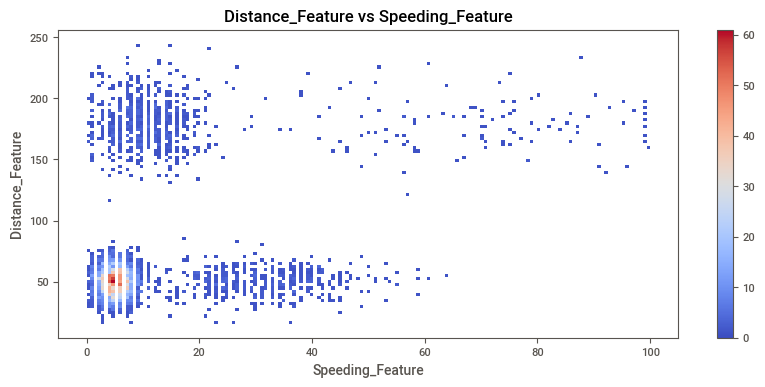

In [736]:
plt.subplots(figsize=(10, 4))
sns.histplot(data=df, y='Distance_Feature', x='Speeding_Feature', cbar=True, cmap='coolwarm')
plt.title("Distance_Feature vs Speeding_Feature")
plt.show()

# Modeling, Raw Data vs. Scaled Data

In the code below, we will test different configurations while training and testing our model
- We will compare results from the use of Raw Data vs. Scaled Date
- We will compare different methods of initialization for the KMean model


## Elbow Method (choose the best $k$) and Silhouette Score


**What is a good clustering?**
- **Minimize Intra-class Variance**: members of the same cluster are very close
- **Maximize Inter-class Variance**: separate clusters as much as possible, ensuring they are distinct from each other

**Inertia**
- Measure the spread/dispersion of data within a cluster (how compact the clusters are)  
- Lower inertia suggests better clustering


**Silhouette Score**
- Measures how well-separated and well-formed clusters are
- The higher, the better

$$  \text{Silhouette Score is} = 
\begin{cases}
    = 1 \text{ , means the point is perfectly match to its cluster}\\
    = 0 \text{ , means the point is on the border between clusters} \\
    < 0 \text{ , means the point might belong to another cluster}
\end{cases} 
$$

So for our analysis, we will focus on:
- **Having the highest Silhouette Score possible**
- **Choose the optimal k for a low inertia**

The kmean's init parameter `k-mean++`:
- It is a smarter way to initialize centroids in the KMeans clustering
- Leads to more accurate and stable clusters compared to random initialization
  - The first centroid is selected randomly
  - Then, the next centroids are picked based on distance: points farther from the already chosen centroids are more likely to be selected
  - Ensuring centroids are placed in diverse regions of the data

In [737]:
def elbow_method(model_params, X):
    assert model_params.get('name') in ['kmean']
    assert model_params.get('init') in ['random', 'k-means++']
    # Start at 2 because silhouette score is undefined for k=1
    k_range = range(2, 15)  
    inertia = []
    silhouette_scores = []

    # Perform K-means clustering for each k and compute metrics
    for k in k_range:
        if model_params['name'] == 'kmean':
            model = KMeans(n_clusters=k, random_state=42, init=model_params['init'])
        model.fit(X)
        inertia.append(model.inertia_)
        labels = model.labels_
        silhouette_scores.append(silhouette_score(X, labels))

    # Store the results in a DataFrame for easy plotting
    results_df = pd.DataFrame({
        'k': k_range,
        'Inertia': inertia,
        'Silhouette': silhouette_scores
    })
    return results_df

In [833]:
# Extract the features for clustering: Speed and Distance
X = df[['Distance_Feature', 'Speeding_Feature']]

# Standardized features
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)

# Min Max Scaled
norm = MinMaxScaler()
X_minmax = norm.fit_transform(X)

In [834]:
results_list = []
configs = []
Xs = {'Raw X': X, 'X_stand': X_stand, 'X_minmax': X_minmax}
for X_dico, init in list(itertools.product(Xs.items(), ['random', 'k-means++'])):
    X_name, X = X_dico
    config = f'{X_name} + {init}'    
    model_params = {'name': 'kmean', 'init': init}
    print(config)
    result = elbow_method(model_params=model_params, X=X)
    results_list.append(result)
    configs.append(config)

Raw X + random
Raw X + k-means++
X_stand + random
X_stand + k-means++
X_minmax + random
X_minmax + k-means++


___

### Interpretation

**From Elbow Method**
- The higher the value of $k$, the smaller the inertia
    > - As $k$ increases, each cluster gets smaller and more specific, reducing the distance between points and centroids
    > - Higher $k$ improves fit but increases complexity, as clusters might capture noise rather than meaningful structure
    >

**Trade-off Between Complexity and Accuray**
- The elbow point represents the optimal trade-off
    > The point where adding more clusters stops providing significant improvement

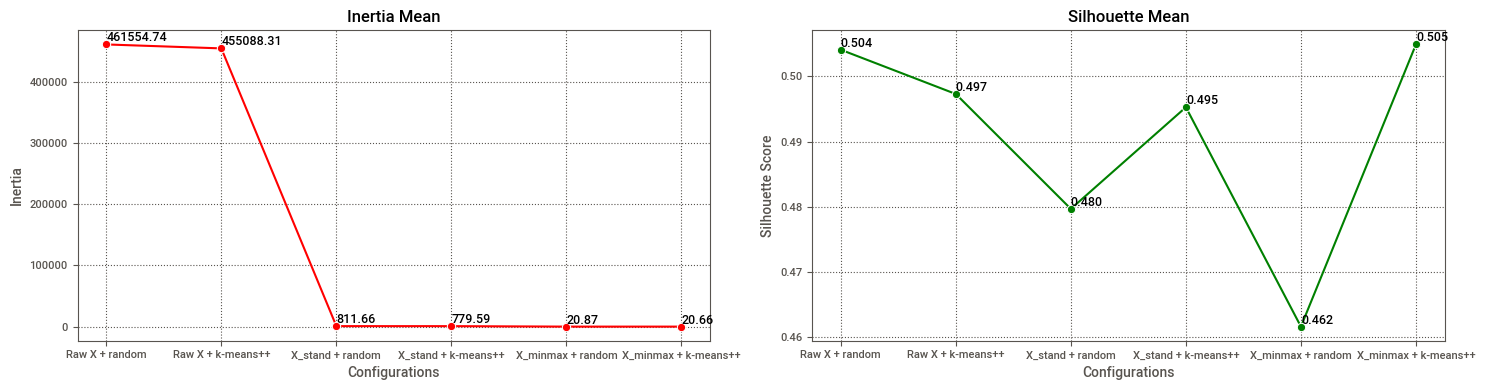

In [1270]:
inertia_mean = [r.mean()['Inertia'] for r in results_list]
Silhouette_mean = [r.mean()['Silhouette'] for r in results_list]
    
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot: Inertia
sns.lineplot(ax=axes[0], x=configs, y=inertia_mean, marker='o', c='r', markersize=6)
for x, y in zip(configs, inertia_mean):
    axes[0].text(x, y, f'{y:.2f}', fontsize=9, ha='left', va='bottom', color='black')
axes[0].set_title("Inertia Mean")
axes[0].set_xlabel("Configurations")
axes[0].set_ylabel("Inertia")
axes[0].grid(True, linestyle=':')

# Plot Silhouette
sns.lineplot(ax=axes[1], x=configs, y=Silhouette_mean, marker='o', c='g', markersize=6)
for x, y in zip(configs, Silhouette_mean):
    axes[1].text(x, y, f'{y:.3f}', fontsize=9, ha='left', va='bottom', color='black')
axes[1].set_title("Silhouette Mean")
axes[1].set_xlabel("Configurations")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

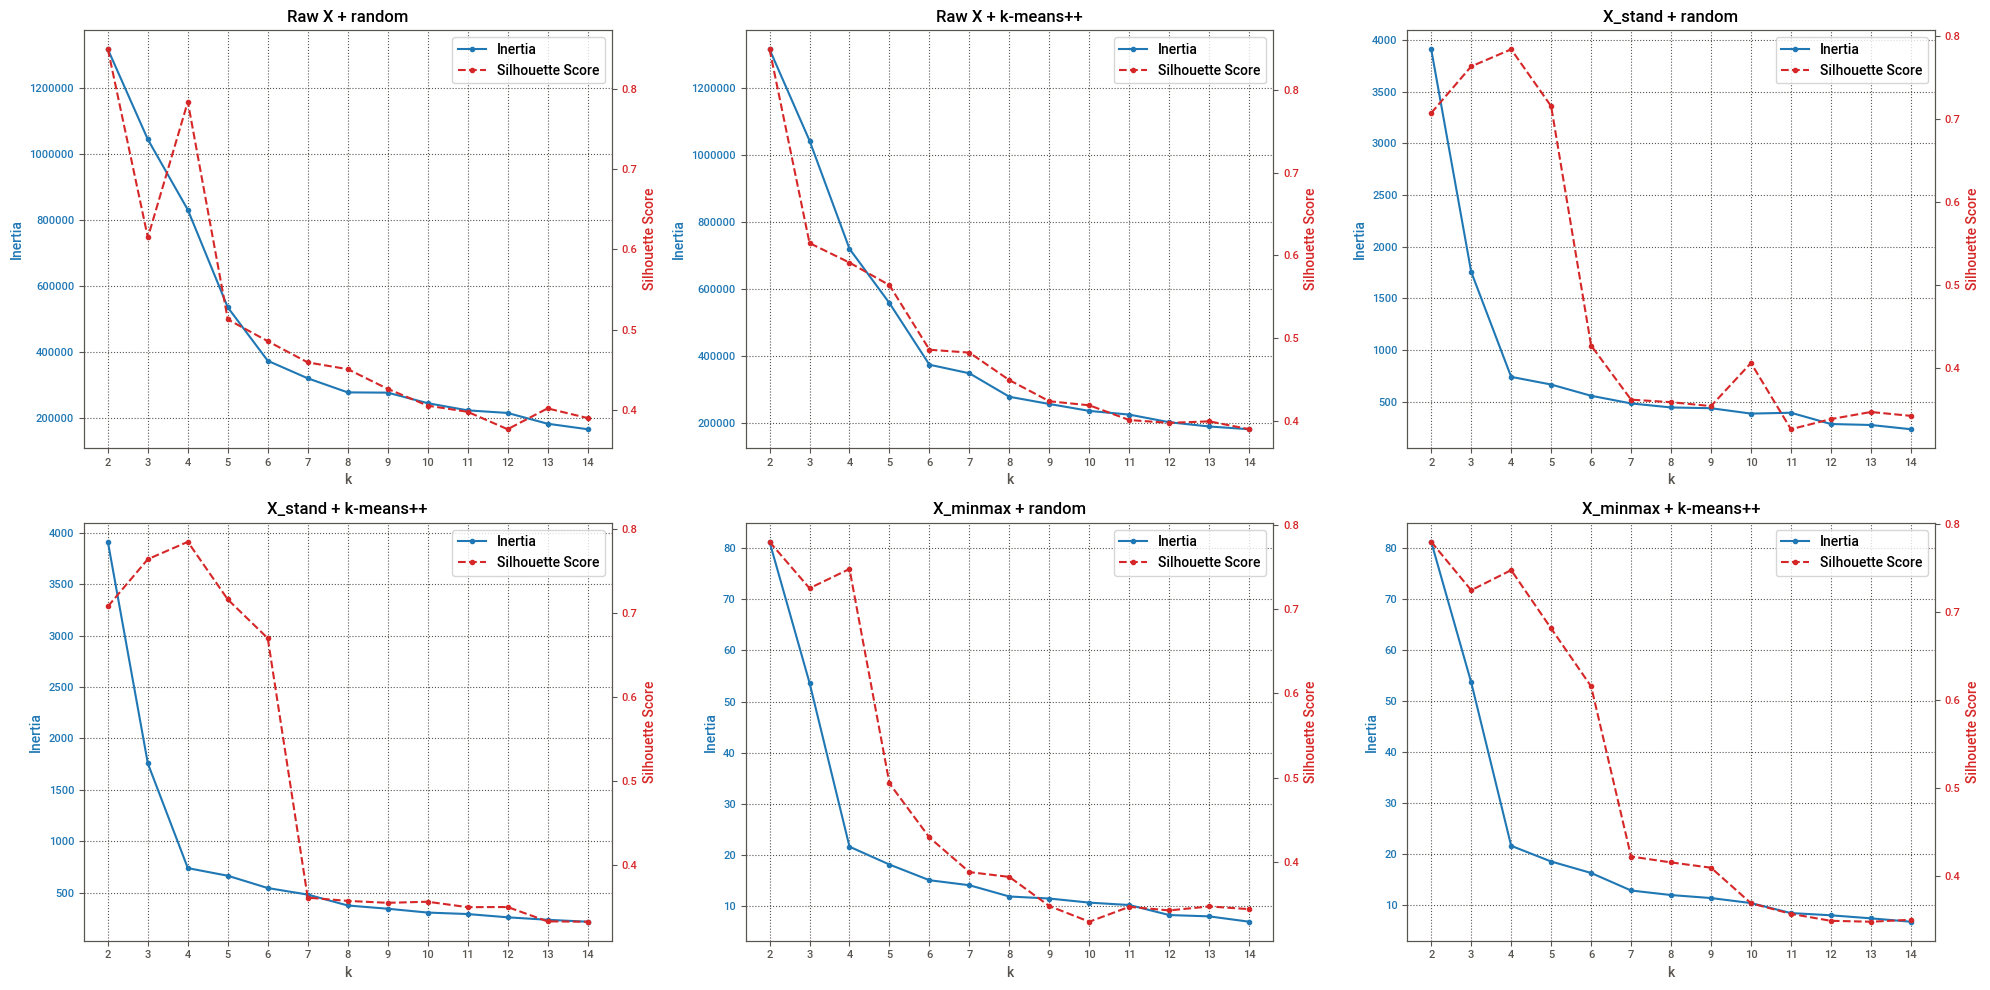

In [847]:
n_dfs = len(results_list)
n_cols = 3
n_rows = int(np.ceil(n_dfs / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()  
for i, dfi in enumerate(results_list):
    ax1 = axes[i]
    
    # Plot Inertia on the primary y-axis
    color1 = 'tab:blue'
    ax1.plot(dfi['k'], dfi['Inertia'], marker='o', color=color1, label='Inertia')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xticks(dfi['k'])

    # Add secondary y-axis for Silhouette Score
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(dfi['k'], dfi['Silhouette'], marker='o', linestyle='--', color=color2, label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_xticks(dfi['k'])
    ax1.grid(True, linestyle=':') 
    ax1.set_title(f'{configs[i]}')
    #ax1.axvline(x=best_k, color='red', linestyle=':', label='Best number of clusters')

    # Combine legends for both y-axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

## Model Selection

From the graphs above, we pick:
- (X_minmax + k-means++) or (X_stand + k-means++)
- k = 4

___

### Interpretation of the model results

<br>

**Inertia** indicates the total sum of squared distances for the given number of clusters
- For the value of $k$ chosen from the Elbow method
> That represent the optimal balance between:
    > - having enough clusters to reduce inertia 
    > - and not overfitting by using too many clusters

<br>


**Silhouette Score** $\in [-1, 1]$   
- 0.7844 (for X_stand + k-means++) and 0.747 (for X_minmax + k-means++) suggests that
> **Our clustering is quite good**
> 
> **With clusters that are both well-separated and well-defined**



In [1232]:
def plot_cluster(k, X_scaled, init='k-means++', df=df):
    kmeans = KMeans(n_clusters=k, random_state=42, init=init)
    kmeans.fit(X_scaled) 
    print(kmeans)

    labels = kmeans.labels_
    print(f'\nInertia : {kmeans.inertia_}')
    print(f'Silhouette Score : {silhouette_score(X_scaled, labels)}\n')

    df['Cluster'] = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_

    print(df['Cluster'].value_counts().reset_index().to_markdown())
    
    # Plot the clusters                 
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df, x=X_scaled[:, 1], y=X_scaled[:, 0], palette='Set2', hue='Cluster', s=20)
    plt.scatter(centroids[:,1], centroids[:,0], s=100, c='red', marker='*', edgecolors='r', label='Centroids')
    plt.legend(title="Clusters", loc="best")
    plt.xlabel('Distance_Feature')
    plt.ylabel('Speeding_Feature')
    plt.title('K-means Clustering of Drivers')
    plt.show()

KMeans(n_clusters=4, random_state=42)

Inertia : 21.627961552686816
Silhouette Score : 0.7474084657864218

|    |   Cluster |   count |
|---:|----------:|--------:|
|  0 |         0 |    2773 |
|  1 |         1 |     696 |
|  2 |         2 |     427 |
|  3 |         3 |     104 |


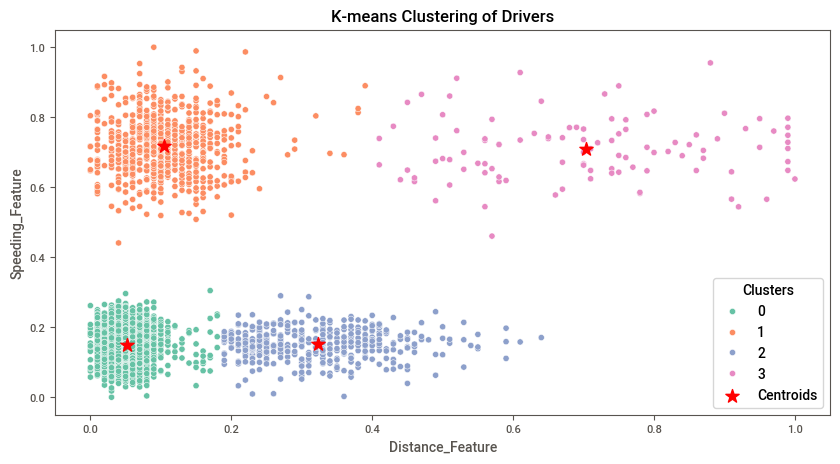

In [1233]:
plot_cluster(k=4, X_scaled=X_minmax)

KMeans(n_clusters=4, random_state=42)

Inertia : 739.1534508645582
Silhouette Score : 0.7843727073779401

|    |   Cluster |   count |
|---:|----------:|--------:|
|  0 |         0 |    2774 |
|  1 |         1 |     695 |
|  2 |         2 |     427 |
|  3 |         3 |     104 |


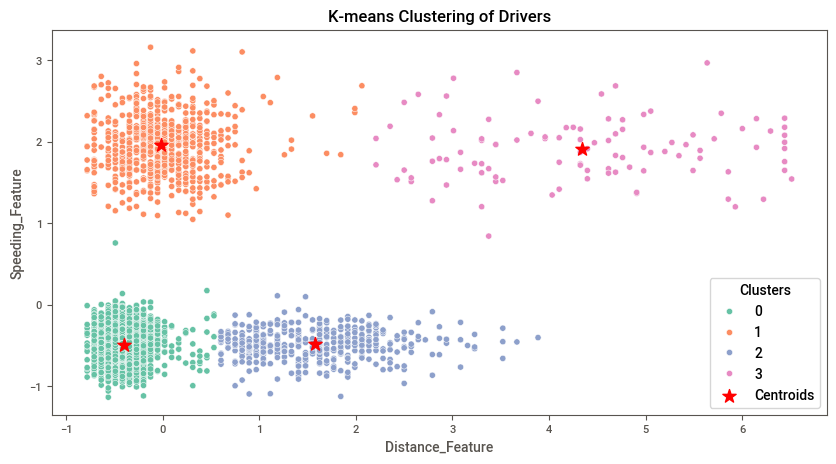

In [1234]:
plot_cluster(k=4, X_scaled=X_stand)